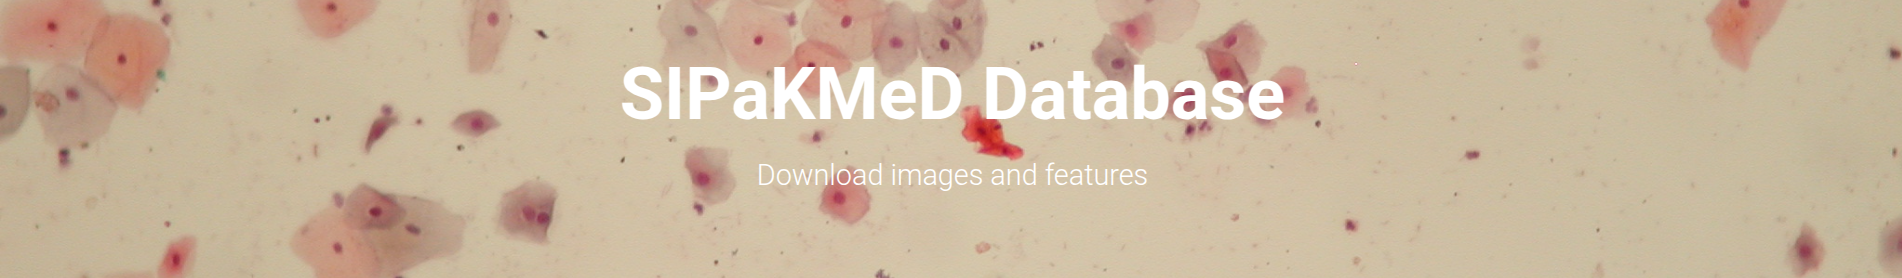

The SIPaKMeD database is publicly available and it can be used for experimental purposes with the request to cite the following paper:

**Marina E. Plissiti, Panagiotis Dimitrakopoulos, Giorgos Sfikas, Christophoros Nikou, Olga Krikoni, Antonia Charchanti, SIPAKMED: A new dataset for feature and image based classification of normal and pathological cervical cells in Pap smear images, IEEE International Conference on Image Processing (ICIP) 2018, Athens, Greece, 7-10 October 2018.**

In [1]:
import os, sys
PROJECT_ROOT = os.path.abspath(os.path.join("../.."))
sys.path.append(PROJECT_ROOT)


In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import cv2
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import torch.optim as optim         
from matplotlib import pyplot as plt

import json, logging
import math

from utils.utils import set_seed, get_device, save_history, load_history
from src.uncertainty_Quantification.train import train_model,train_deep_ensemble, get_dataloader
from src.uncertainty_Quantification.test import evaluate_model, evaluate_deep_ensemble, evaluate_mc_dropout
from src.uncertainty_Quantification.models import SingleNetwork, MCDropoutNetwork, DeepEnsemble
from src.uncertainty_Quantification.losses import edl_mse_loss, edl_digamma_loss, edl_log_loss, relu_evidence 
# from src.uncertainty_Quantification.metrics import 

set_seed(42)

DEVICE = get_device()

/home/conite/anaconda3/envs/GPU_ENV/lib/python3.9/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789115370/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


**01. Load & Explore the Data**

In [40]:


DATASET_PATH = "../../datasets/SIPaKMeD"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

def load_dataset(dataset_path):
    """
    Loads the dataset by scanning directories for `.bmp` images.
    Returns:
    - file_paths: Dict with class names as keys and list of image paths as values
    - class_counts: Dict with class names as keys and count of images as values
    """
    file_paths = {}
    class_counts = {}

    for class_name in sorted(os.listdir(dataset_path)):  
        class_dir = os.path.join(dataset_path, class_name, "CROPPED")
        if os.path.isdir(class_dir):
            bmp_files = [os.path.join(class_dir, f) for f in os.listdir(class_dir) if f.endswith(".bmp")]
            file_paths[class_name] = bmp_files
            class_counts[class_name] = len(bmp_files)

    return file_paths, class_counts

def visualize_class_distribution(class_counts):
    """
    Plots a bar chart showing class distribution.
    """
    plt.figure(figsize=(8, 6))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")
    plt.title("Class Distribution in SIPaKMeD Dataset")
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=20)
    plt.show()
    
    

def plot_sample_images(file_paths, num_samples=5):
    """
    Plots sample images from each class.
    """
    fig, axes = plt.subplots(len(file_paths), num_samples, figsize=(num_samples * 2, len(file_paths) * 2))

    for i, (class_name, paths) in enumerate(file_paths.items()):
        sample_paths = np.random.choice(paths, num_samples, replace=False) if len(paths) >= num_samples else paths
        for j, img_path in enumerate(sample_paths):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i, j].imshow(img)
            axes[i, j].axis("off")
            if j == 0:
                axes[i, j].set_title(class_name, fontsize=12, fontweight="bold")
    
    plt.tight_layout()
    plt.show()


Class Counts: {'im_Dyskeratotic': 813, 'im_Koilocytotic': 825, 'im_Metaplastic': 793, 'im_Parabasal': 787, 'im_Superficial-Intermediate': 831}


/tmp/ipykernel_1207333/1747648437.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")


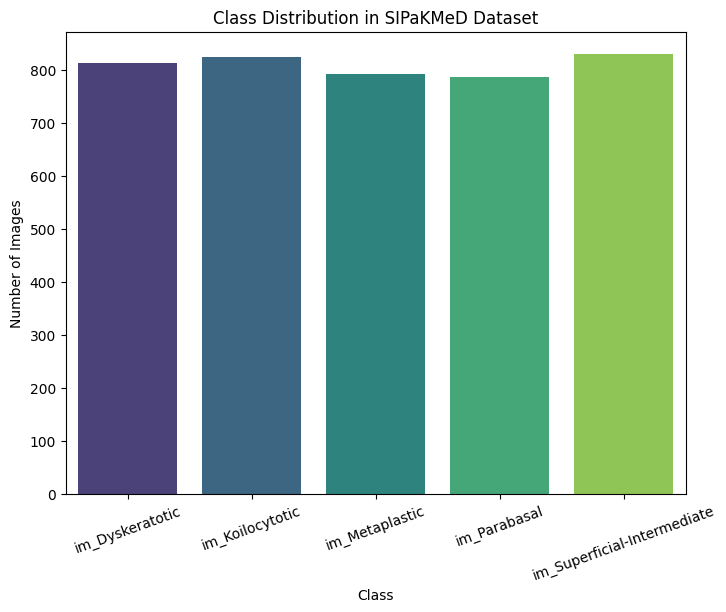

In [9]:
file_paths, class_counts = load_dataset(DATASET_PATH)
print(f"Class Counts: {class_counts}")
visualize_class_distribution(class_counts)


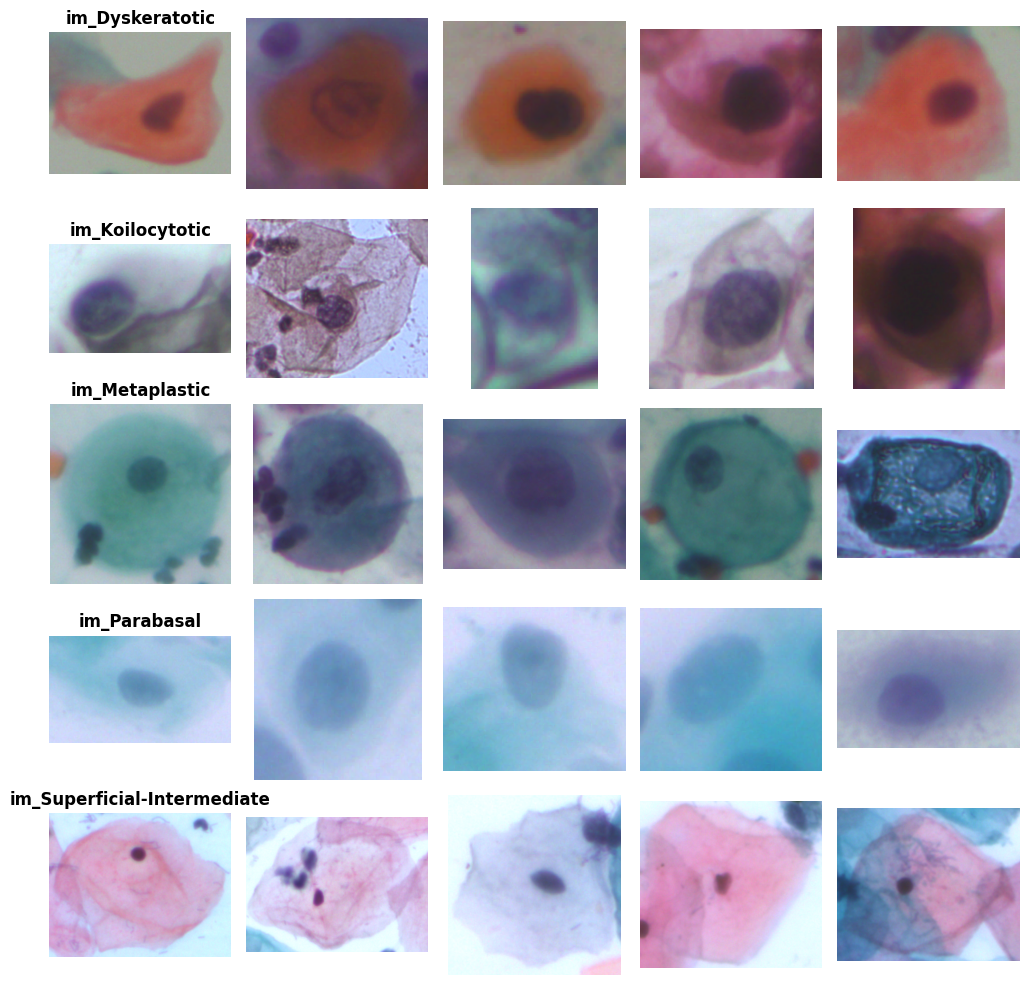

In [10]:
plot_sample_images(file_paths, num_samples=5)

**02. Data Preprocessing.**

* split data

In [ ]:
!python ../Datasets/split.py

**03. Feature Extraction**

* 3.1 Models for extraction

* `ResNet50`
* `InceptionV3`
* `EfficientNetB7`

**04. Feature visualization (PCA/t-SNE)**


- How separable the features are across classes.

- The effectiveness of ResNet50 vs. DenseNet121 in feature extraction.

- How well the extracted features preserve class structure.

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

FEATURES_PATH = "../Feature_Extraction"

def load_extracted_features(model_name, split_name='train'):
    feature_path = os.path.join(FEATURES_PATH, f"{model_name}_{split_name}_features.npy")
    label_path = os.path.join(FEATURES_PATH, f"{split_name}_labels.npy")
    
    X = np.load(feature_path)
    if len(X.shape) > 2:
        X = X.reshape(X.shape[0], -1)
    y = np.load(label_path)
    
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X, y

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

FEATURES_PATH = "../Feature_Extraction"

def visualize_tsne(models=["ResNet50", "DenseNet121"], split="train", perplexity=30, n_iter=1000, n_pca=50):
    """
    Generates side-by-side t-SNE visualizations for different models with class colors.

    Parameters:
    - models: List of model names whose features to visualize.
    - split: Dataset split to visualize (default is "train").
    - perplexity: t-SNE perplexity parameter (default=30).
    - n_iter: Number of t-SNE iterations (default=1000).
    - n_pca: Number of PCA components before applying t-SNE (default=50).

    The function automatically loads features, applies PCA, then t-SNE, and plots results.
    """
    fig, axes = plt.subplots(1, len(models), figsize=(7 * len(models), 6))

    if len(models) == 1:
        axes = [axes]

    label_path = os.path.join(FEATURES_PATH, f"{split}_labels.npy")
    if not os.path.exists(label_path):
        raise FileNotFoundError(f"Labels file not found: {label_path}")
    y_labels = np.load(label_path)
    
    num_classes = len(np.unique(y_labels))
    palette = sns.color_palette("husl", num_classes)

    for i, model_name in enumerate(models):
        feature_path = os.path.join(FEATURES_PATH, f"{model_name}_{split}_features.npy")
        
        if not os.path.exists(feature_path):
            print(f"Skipping {model_name}: Feature file not found: {feature_path}")
            continue
        
        X_features = np.load(feature_path)

        if len(X_features.shape) > 2:
            X_features = X_features.reshape(X_features.shape[0], -1)

        pca = PCA(n_components=n_pca)
        X_pca = pca.fit_transform(X_features)

        tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, random_state=42)
        X_tsne = tsne.fit_transform(X_pca)

        sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_labels, palette=palette, alpha=0.7, ax=axes[i])
        axes[i].set_title(f"t-SNE Visualization - {model_name}")
        axes[i].set_xlabel("t-SNE Component 1")
        axes[i].set_ylabel("t-SNE Component 2")

    plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


In [ ]:
visualize_tsne(models=["ResNet50", "EfficientNetB7"])

**05. Train the Models**

In [3]:
set_seed(42)
EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
PATIENCE =10
ENSEMBLE_SIZE = 10
NUM_SAMPLES = 10

train_loader = get_dataloader("train", BATCH_SIZE)
val_loader = get_dataloader("val", BATCH_SIZE)

input_dim = train_loader.dataset.tensors[0].shape[1]
num_classes = len(set(train_loader.dataset.tensors[1].numpy()))
print(f"Input Dimension: {input_dim}, Num Classes: {num_classes}")

Input Dimension: 2048, Num Classes: 5


In [13]:
#======================
# 📌 Single Network   =
#======================

single_net = SingleNetwork(input_dim, num_classes).to(DEVICE)
optimizer = torch.optim.Adam(single_net.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss()
train_model(single_net, train_loader, val_loader, criterion, optimizer, EPOCHS, "SingleNetwork", PATIENCE)


INFO:SingleNetwork:Starting training for SingleNetwork


Training SingleNetwork for 50 epochs


INFO:SingleNetwork:Epoch 1/50 | Train Loss: 82.2566 | Val Loss: 1.9784 | Val Acc: 0.9145 | Val F1: 0.9131 | Val Recall: 0.9145 | Val Precision: 0.9181
INFO:SingleNetwork:Validation loss decreased to 1.9784. Saving model...
INFO:SingleNetwork:Epoch 2/50 | Train Loss: 31.2104 | Val Loss: 1.4474 | Val Acc: 0.9276 | Val F1: 0.9257 | Val Recall: 0.9276 | Val Precision: 0.9340
INFO:SingleNetwork:Validation loss decreased to 1.4474. Saving model...
INFO:SingleNetwork:Epoch 3/50 | Train Loss: 23.8103 | Val Loss: 1.3768 | Val Acc: 0.9276 | Val F1: 0.9259 | Val Recall: 0.9276 | Val Precision: 0.9328
INFO:SingleNetwork:Validation loss decreased to 1.3768. Saving model...
INFO:SingleNetwork:Epoch 4/50 | Train Loss: 19.5985 | Val Loss: 1.0397 | Val Acc: 0.9539 | Val F1: 0.9532 | Val Recall: 0.9539 | Val Precision: 0.9564
INFO:SingleNetwork:Validation loss decreased to 1.0397. Saving model...
INFO:SingleNetwork:Epoch 5/50 | Train Loss: 16.8556 | Val Loss: 1.0248 | Val Acc: 0.9342 | Val F1: 0.9333 | 

Training complete for SingleNetwork


In [7]:
#======================
#  📌 Deep Ensemble   =
#======================
ensemble_models = train_deep_ensemble(
    train_loader, val_loader, ensemble_size=ENSEMBLE_SIZE, 
    learning_rate=LEARNING_RATE, epochs=EPOCHS
)

INFO:DeepEnsemble:Starting Deep Ensemble Training with 10 models
INFO:DeepEnsemble_0:Starting training for DeepEnsemble_0


Training DeepEnsemble_0 for 50 epochs


INFO:DeepEnsemble_0:Epoch 1/50 | Train Loss: 85.6539 | Val Loss: 2.1001 | Val Acc: 0.9013 | Val F1: 0.8983 | Val Recall: 0.9013 | Val Precision: 0.9055
INFO:DeepEnsemble_0:Validation loss decreased to 2.1001. Saving model...
INFO:DeepEnsemble_0:Epoch 2/50 | Train Loss: 33.1528 | Val Loss: 1.3820 | Val Acc: 0.9276 | Val F1: 0.9257 | Val Recall: 0.9276 | Val Precision: 0.9284
INFO:DeepEnsemble_0:Validation loss decreased to 1.3820. Saving model...
INFO:DeepEnsemble_0:Epoch 3/50 | Train Loss: 24.7633 | Val Loss: 1.0929 | Val Acc: 0.9408 | Val F1: 0.9394 | Val Recall: 0.9408 | Val Precision: 0.9418
INFO:DeepEnsemble_0:Validation loss decreased to 1.0929. Saving model...
INFO:DeepEnsemble_0:Epoch 4/50 | Train Loss: 20.8682 | Val Loss: 1.0029 | Val Acc: 0.9474 | Val F1: 0.9462 | Val Recall: 0.9474 | Val Precision: 0.9468
INFO:DeepEnsemble_0:Validation loss decreased to 1.0029. Saving model...
INFO:DeepEnsemble_0:Epoch 5/50 | Train Loss: 18.0619 | Val Loss: 1.0636 | Val Acc: 0.9474 | Val F1: 

Training complete for DeepEnsemble_0
Training DeepEnsemble_1 for 50 epochs


INFO:DeepEnsemble_1:Epoch 1/50 | Train Loss: 82.6791 | Val Loss: 2.2411 | Val Acc: 0.8882 | Val F1: 0.8847 | Val Recall: 0.8882 | Val Precision: 0.9007
INFO:DeepEnsemble_1:Validation loss decreased to 2.2411. Saving model...
INFO:DeepEnsemble_1:Epoch 2/50 | Train Loss: 32.7210 | Val Loss: 1.4299 | Val Acc: 0.9145 | Val F1: 0.9137 | Val Recall: 0.9145 | Val Precision: 0.9184
INFO:DeepEnsemble_1:Validation loss decreased to 1.4299. Saving model...
INFO:DeepEnsemble_1:Epoch 3/50 | Train Loss: 24.0665 | Val Loss: 1.1174 | Val Acc: 0.9408 | Val F1: 0.9401 | Val Recall: 0.9408 | Val Precision: 0.9453
INFO:DeepEnsemble_1:Validation loss decreased to 1.1174. Saving model...
INFO:DeepEnsemble_1:Epoch 4/50 | Train Loss: 20.8077 | Val Loss: 1.1676 | Val Acc: 0.9408 | Val F1: 0.9396 | Val Recall: 0.9408 | Val Precision: 0.9439
INFO:DeepEnsemble_1:No improvement for 1 epochs
INFO:DeepEnsemble_1:Epoch 5/50 | Train Loss: 17.9703 | Val Loss: 0.9007 | Val Acc: 0.9474 | Val F1: 0.9465 | Val Recall: 0.94

Training complete for DeepEnsemble_1
Training DeepEnsemble_2 for 50 epochs


INFO:DeepEnsemble_2:Epoch 1/50 | Train Loss: 84.5153 | Val Loss: 2.1831 | Val Acc: 0.9013 | Val F1: 0.8992 | Val Recall: 0.9013 | Val Precision: 0.9010
INFO:DeepEnsemble_2:Validation loss decreased to 2.1831. Saving model...
INFO:DeepEnsemble_2:Epoch 2/50 | Train Loss: 32.9820 | Val Loss: 1.5391 | Val Acc: 0.8947 | Val F1: 0.8921 | Val Recall: 0.8947 | Val Precision: 0.9021
INFO:DeepEnsemble_2:Validation loss decreased to 1.5391. Saving model...
INFO:DeepEnsemble_2:Epoch 3/50 | Train Loss: 24.9141 | Val Loss: 1.2395 | Val Acc: 0.9342 | Val F1: 0.9324 | Val Recall: 0.9342 | Val Precision: 0.9409
INFO:DeepEnsemble_2:Validation loss decreased to 1.2395. Saving model...
INFO:DeepEnsemble_2:Epoch 4/50 | Train Loss: 20.6587 | Val Loss: 1.0041 | Val Acc: 0.9539 | Val F1: 0.9526 | Val Recall: 0.9539 | Val Precision: 0.9564
INFO:DeepEnsemble_2:Validation loss decreased to 1.0041. Saving model...
INFO:DeepEnsemble_2:Epoch 5/50 | Train Loss: 17.3235 | Val Loss: 1.0371 | Val Acc: 0.9474 | Val F1: 

Training complete for DeepEnsemble_2
Training DeepEnsemble_3 for 50 epochs


INFO:DeepEnsemble_3:Epoch 1/50 | Train Loss: 81.1107 | Val Loss: 2.0616 | Val Acc: 0.8750 | Val F1: 0.8699 | Val Recall: 0.8750 | Val Precision: 0.8829
INFO:DeepEnsemble_3:Validation loss decreased to 2.0616. Saving model...
INFO:DeepEnsemble_3:Epoch 2/50 | Train Loss: 31.3565 | Val Loss: 1.3615 | Val Acc: 0.9211 | Val F1: 0.9199 | Val Recall: 0.9211 | Val Precision: 0.9208
INFO:DeepEnsemble_3:Validation loss decreased to 1.3615. Saving model...
INFO:DeepEnsemble_3:Epoch 3/50 | Train Loss: 23.6906 | Val Loss: 1.1490 | Val Acc: 0.9474 | Val F1: 0.9463 | Val Recall: 0.9474 | Val Precision: 0.9508
INFO:DeepEnsemble_3:Validation loss decreased to 1.1490. Saving model...
INFO:DeepEnsemble_3:Epoch 4/50 | Train Loss: 20.0565 | Val Loss: 1.0434 | Val Acc: 0.9408 | Val F1: 0.9394 | Val Recall: 0.9408 | Val Precision: 0.9418
INFO:DeepEnsemble_3:Validation loss decreased to 1.0434. Saving model...
INFO:DeepEnsemble_3:Epoch 5/50 | Train Loss: 16.9666 | Val Loss: 1.0065 | Val Acc: 0.9408 | Val F1: 

Training complete for DeepEnsemble_3
Training DeepEnsemble_4 for 50 epochs


INFO:DeepEnsemble_4:Epoch 1/50 | Train Loss: 82.5259 | Val Loss: 2.2027 | Val Acc: 0.8816 | Val F1: 0.8776 | Val Recall: 0.8816 | Val Precision: 0.8954
INFO:DeepEnsemble_4:Validation loss decreased to 2.2027. Saving model...
INFO:DeepEnsemble_4:Epoch 2/50 | Train Loss: 31.9260 | Val Loss: 1.4106 | Val Acc: 0.9276 | Val F1: 0.9260 | Val Recall: 0.9276 | Val Precision: 0.9307
INFO:DeepEnsemble_4:Validation loss decreased to 1.4106. Saving model...
INFO:DeepEnsemble_4:Epoch 3/50 | Train Loss: 23.9028 | Val Loss: 1.3716 | Val Acc: 0.9276 | Val F1: 0.9255 | Val Recall: 0.9276 | Val Precision: 0.9331
INFO:DeepEnsemble_4:Validation loss decreased to 1.3716. Saving model...
INFO:DeepEnsemble_4:Epoch 4/50 | Train Loss: 19.5062 | Val Loss: 0.9850 | Val Acc: 0.9408 | Val F1: 0.9394 | Val Recall: 0.9408 | Val Precision: 0.9418
INFO:DeepEnsemble_4:Validation loss decreased to 0.9850. Saving model...
INFO:DeepEnsemble_4:Epoch 5/50 | Train Loss: 17.3861 | Val Loss: 0.9615 | Val Acc: 0.9408 | Val F1: 

Training complete for DeepEnsemble_4
Training DeepEnsemble_5 for 50 epochs


INFO:DeepEnsemble_5:Epoch 1/50 | Train Loss: 79.3255 | Val Loss: 1.9988 | Val Acc: 0.8816 | Val F1: 0.8775 | Val Recall: 0.8816 | Val Precision: 0.8871
INFO:DeepEnsemble_5:Validation loss decreased to 1.9988. Saving model...
INFO:DeepEnsemble_5:Epoch 2/50 | Train Loss: 31.9237 | Val Loss: 1.3898 | Val Acc: 0.9079 | Val F1: 0.9067 | Val Recall: 0.9079 | Val Precision: 0.9131
INFO:DeepEnsemble_5:Validation loss decreased to 1.3898. Saving model...
INFO:DeepEnsemble_5:Epoch 3/50 | Train Loss: 24.1121 | Val Loss: 1.0444 | Val Acc: 0.9474 | Val F1: 0.9463 | Val Recall: 0.9474 | Val Precision: 0.9508
INFO:DeepEnsemble_5:Validation loss decreased to 1.0444. Saving model...
INFO:DeepEnsemble_5:Epoch 4/50 | Train Loss: 19.9417 | Val Loss: 1.1928 | Val Acc: 0.9276 | Val F1: 0.9253 | Val Recall: 0.9276 | Val Precision: 0.9364
INFO:DeepEnsemble_5:No improvement for 1 epochs
INFO:DeepEnsemble_5:Epoch 5/50 | Train Loss: 16.7128 | Val Loss: 0.8608 | Val Acc: 0.9605 | Val F1: 0.9596 | Val Recall: 0.96

Training complete for DeepEnsemble_5
Training DeepEnsemble_6 for 50 epochs


INFO:DeepEnsemble_6:Epoch 1/50 | Train Loss: 85.4039 | Val Loss: 2.1413 | Val Acc: 0.9013 | Val F1: 0.8992 | Val Recall: 0.9013 | Val Precision: 0.9070
INFO:DeepEnsemble_6:Validation loss decreased to 2.1413. Saving model...
INFO:DeepEnsemble_6:Epoch 2/50 | Train Loss: 33.2937 | Val Loss: 1.4066 | Val Acc: 0.9408 | Val F1: 0.9401 | Val Recall: 0.9408 | Val Precision: 0.9453
INFO:DeepEnsemble_6:Validation loss decreased to 1.4066. Saving model...
INFO:DeepEnsemble_6:Epoch 3/50 | Train Loss: 24.2047 | Val Loss: 1.0929 | Val Acc: 0.9408 | Val F1: 0.9392 | Val Recall: 0.9408 | Val Precision: 0.9419
INFO:DeepEnsemble_6:Validation loss decreased to 1.0929. Saving model...
INFO:DeepEnsemble_6:Epoch 4/50 | Train Loss: 21.0168 | Val Loss: 1.0208 | Val Acc: 0.9342 | Val F1: 0.9334 | Val Recall: 0.9342 | Val Precision: 0.9383
INFO:DeepEnsemble_6:Validation loss decreased to 1.0208. Saving model...
INFO:DeepEnsemble_6:Epoch 5/50 | Train Loss: 17.0781 | Val Loss: 0.8750 | Val Acc: 0.9605 | Val F1: 

Training complete for DeepEnsemble_6
Training DeepEnsemble_7 for 50 epochs


INFO:DeepEnsemble_7:Epoch 1/50 | Train Loss: 82.8979 | Val Loss: 2.0801 | Val Acc: 0.9013 | Val F1: 0.9005 | Val Recall: 0.9013 | Val Precision: 0.9060
INFO:DeepEnsemble_7:Validation loss decreased to 2.0801. Saving model...
INFO:DeepEnsemble_7:Epoch 2/50 | Train Loss: 32.1117 | Val Loss: 1.3374 | Val Acc: 0.9342 | Val F1: 0.9332 | Val Recall: 0.9342 | Val Precision: 0.9342
INFO:DeepEnsemble_7:Validation loss decreased to 1.3374. Saving model...
INFO:DeepEnsemble_7:Epoch 3/50 | Train Loss: 23.7120 | Val Loss: 1.0956 | Val Acc: 0.9408 | Val F1: 0.9394 | Val Recall: 0.9408 | Val Precision: 0.9418
INFO:DeepEnsemble_7:Validation loss decreased to 1.0956. Saving model...
INFO:DeepEnsemble_7:Epoch 4/50 | Train Loss: 19.2552 | Val Loss: 1.1191 | Val Acc: 0.9211 | Val F1: 0.9197 | Val Recall: 0.9211 | Val Precision: 0.9265
INFO:DeepEnsemble_7:No improvement for 1 epochs
INFO:DeepEnsemble_7:Epoch 5/50 | Train Loss: 17.6885 | Val Loss: 1.0687 | Val Acc: 0.9276 | Val F1: 0.9260 | Val Recall: 0.92

Training complete for DeepEnsemble_7
Training DeepEnsemble_8 for 50 epochs


INFO:DeepEnsemble_8:Epoch 1/50 | Train Loss: 83.6366 | Val Loss: 2.1424 | Val Acc: 0.8882 | Val F1: 0.8847 | Val Recall: 0.8882 | Val Precision: 0.8962
INFO:DeepEnsemble_8:Validation loss decreased to 2.1424. Saving model...
INFO:DeepEnsemble_8:Epoch 2/50 | Train Loss: 33.3313 | Val Loss: 1.3403 | Val Acc: 0.9211 | Val F1: 0.9202 | Val Recall: 0.9211 | Val Precision: 0.9202
INFO:DeepEnsemble_8:Validation loss decreased to 1.3403. Saving model...
INFO:DeepEnsemble_8:Epoch 3/50 | Train Loss: 24.5660 | Val Loss: 1.1730 | Val Acc: 0.9342 | Val F1: 0.9332 | Val Recall: 0.9342 | Val Precision: 0.9342
INFO:DeepEnsemble_8:Validation loss decreased to 1.1730. Saving model...
INFO:DeepEnsemble_8:Epoch 4/50 | Train Loss: 19.5883 | Val Loss: 0.9749 | Val Acc: 0.9408 | Val F1: 0.9397 | Val Recall: 0.9408 | Val Precision: 0.9422
INFO:DeepEnsemble_8:Validation loss decreased to 0.9749. Saving model...
INFO:DeepEnsemble_8:Epoch 5/50 | Train Loss: 17.7724 | Val Loss: 0.9775 | Val Acc: 0.9474 | Val F1: 

Training complete for DeepEnsemble_8
Training DeepEnsemble_9 for 50 epochs


INFO:DeepEnsemble_9:Epoch 1/50 | Train Loss: 83.3688 | Val Loss: 2.1200 | Val Acc: 0.9079 | Val F1: 0.9063 | Val Recall: 0.9079 | Val Precision: 0.9187
INFO:DeepEnsemble_9:Validation loss decreased to 2.1200. Saving model...
INFO:DeepEnsemble_9:Epoch 2/50 | Train Loss: 32.7856 | Val Loss: 1.3189 | Val Acc: 0.9276 | Val F1: 0.9257 | Val Recall: 0.9276 | Val Precision: 0.9284
INFO:DeepEnsemble_9:Validation loss decreased to 1.3189. Saving model...
INFO:DeepEnsemble_9:Epoch 3/50 | Train Loss: 24.4250 | Val Loss: 1.2861 | Val Acc: 0.9408 | Val F1: 0.9398 | Val Recall: 0.9408 | Val Precision: 0.9445
INFO:DeepEnsemble_9:Validation loss decreased to 1.2861. Saving model...
INFO:DeepEnsemble_9:Epoch 4/50 | Train Loss: 19.9419 | Val Loss: 0.9652 | Val Acc: 0.9342 | Val F1: 0.9327 | Val Recall: 0.9342 | Val Precision: 0.9336
INFO:DeepEnsemble_9:Validation loss decreased to 0.9652. Saving model...
INFO:DeepEnsemble_9:Epoch 5/50 | Train Loss: 17.2249 | Val Loss: 0.9339 | Val Acc: 0.9474 | Val F1: 

Training complete for DeepEnsemble_9


In [9]:
#=========================
# 📌 Monte Carlo Dropout =
#=========================

logging.info("Training Monte Carlo Dropout Network...")
mc_dropout_net = MCDropoutNetwork(input_dim, num_classes, dropout_rate=0.4).to(DEVICE)
optimizer = torch.optim.Adam(mc_dropout_net.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss()
train_model(mc_dropout_net, train_loader, val_loader, criterion, optimizer, EPOCHS, "MCDropout", PATIENCE)


INFO:MCDropout:Starting training for MCDropout


Training MCDropout for 50 epochs


INFO:MCDropout:Epoch 1/50 | Train Loss: 99.7395 | Val Loss: 2.6309 | Val Acc: 0.8553 | Val F1: 0.8494 | Val Recall: 0.8553 | Val Precision: 0.8656
INFO:MCDropout:Validation loss decreased to 2.6309. Saving model...
INFO:MCDropout:Epoch 2/50 | Train Loss: 44.0760 | Val Loss: 1.6158 | Val Acc: 0.9013 | Val F1: 0.8980 | Val Recall: 0.9013 | Val Precision: 0.9076
INFO:MCDropout:Validation loss decreased to 1.6158. Saving model...
INFO:MCDropout:Epoch 3/50 | Train Loss: 33.3827 | Val Loss: 1.3484 | Val Acc: 0.9408 | Val F1: 0.9389 | Val Recall: 0.9408 | Val Precision: 0.9443
INFO:MCDropout:Validation loss decreased to 1.3484. Saving model...
INFO:MCDropout:Epoch 4/50 | Train Loss: 29.7843 | Val Loss: 1.1034 | Val Acc: 0.9408 | Val F1: 0.9395 | Val Recall: 0.9408 | Val Precision: 0.9407
INFO:MCDropout:Validation loss decreased to 1.1034. Saving model...
INFO:MCDropout:Epoch 5/50 | Train Loss: 25.4623 | Val Loss: 0.9953 | Val Acc: 0.9408 | Val F1: 0.9394 | Val Recall: 0.9408 | Val Precision: 

Training complete for MCDropout


**Performance**

`Compute average performance of DE`

In [19]:
df = []
RESULTS_PATH = os.path.join(PROJECT_ROOT, "outputs/results")
histories = {}
for i in range(ENSEMBLE_SIZE):
    deep_ensemble_path = os.path.join(RESULTS_PATH, f"DeepEnsemble_{i}_history.json")
    histories[f"Deep Ensemble {i}"] = load_history(deep_ensemble_path)
    df.append(pd.DataFrame.from_dict(load_history(deep_ensemble_path)))
    
    
mean_df = pd.concat(df).groupby(level=0).mean()
mean_df.head() 
save_history(mean_df.to_dict(), os.path.join(RESULTS_PATH, "DeepEnsemble_mean_history.json"))

In [ ]:
# # load json  in df
# RESULTS_PATH = os.path.join(PROJECT_ROOT, "outputs/results")
# single_network_path = os.path.join(RESULTS_PATH, "SingleNetwork_history.json")
# deep_ensemble_path = os.path.join(RESULTS_PATH, "DeepEnsemble_mean_history.json")
# mc_dropout_path = os.path.join(RESULTS_PATH, "MCDropout_history.json")

# single_network_df = pd.DataFrame.from_dict(load_history(single_network_path))
# deep_ensemble_df = pd.DataFrame.from_dict(load_history(deep_ensemble_path))
# mc_dropout_df = pd.DataFrame.from_dict(load_history(mc_dropout_path))



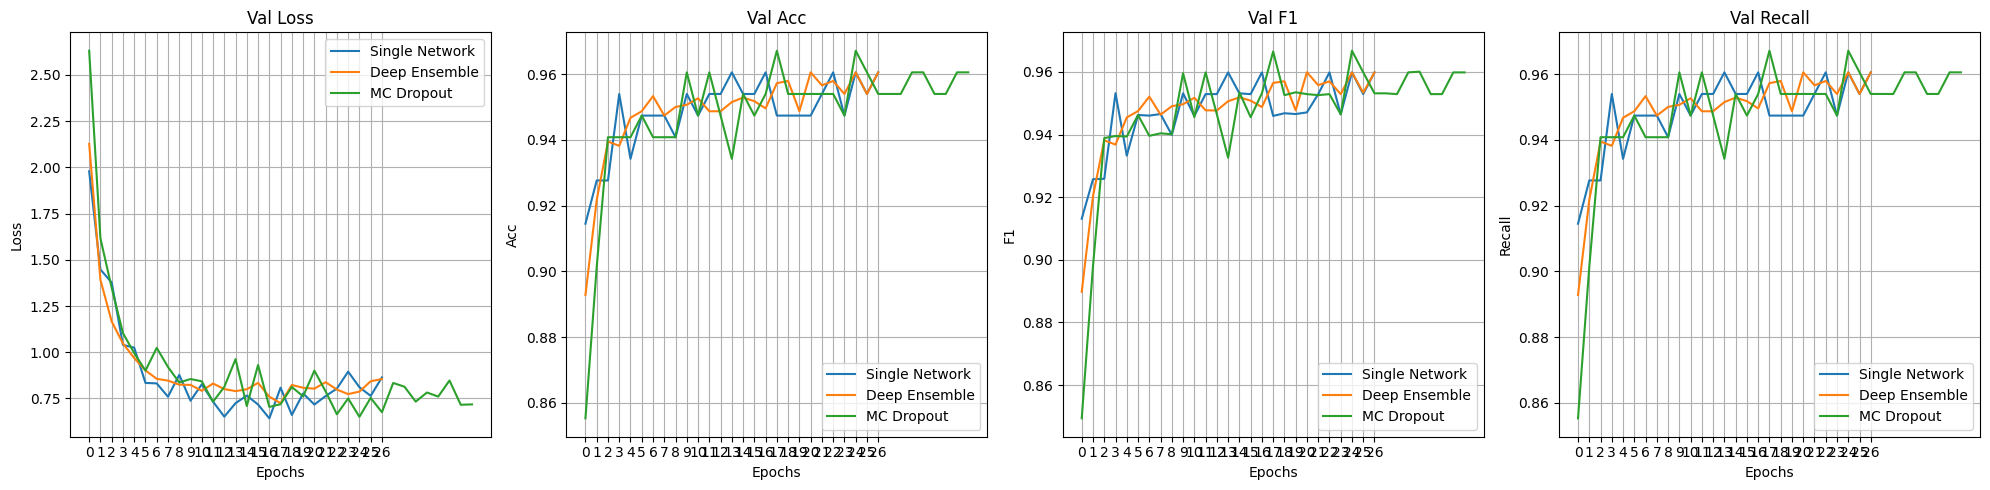

✅ Performance evolution curves saved at: /home/conite/Documents/STAGE/HybridUncertaintyAwareDL/outputs/images/performance_evolution.png


In [ ]:


model_paths = {
    "Single Network": os.path.join(RESULTS_PATH, "SingleNetwork_history.json"),
    "Deep Ensemble": os.path.join(RESULTS_PATH, "DeepEnsemble_mean_history.json"),
    "MC Dropout": os.path.join(RESULTS_PATH, "MCDropout_history.json"),
}


histories = {name: load_history(path) for name, path in model_paths.items()}

def plot_performance_evolution(metrics=["val_loss", "val_acc", "val_f1", "val_recall"], save_path=f"{PROJECT_ROOT}/outputs/images", histories=histories):
    """
    Plots performance evolution for multiple models dynamically adjusting the number of columns.
    
    Args:
        metrics (list): List of validation metrics to plot.
        save_path (str): Directory to save the plots.

    Returns:
        None
    """
    num_metrics = len(metrics)
    num_cols = min(num_metrics, 4) 
    num_rows = math.ceil(num_metrics / num_cols)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))
    axs = axs.flatten()  
    for idx, metric in enumerate(metrics):
        for model_name, df in histories.items():
            if df is not None and metric in df:
                axs[idx].plot(df.index, df[metric], label=model_name)
        
        axs[idx].set_title(metric.replace("_", " ").title())  # Format title
        axs[idx].set_xlabel("Epochs")
        axs[idx].set_ylabel(metric.split("_")[-1].title())
        axs[idx].legend()
        axs[idx].grid(True)

    # Hide unused subplots if necessary
    for i in range(len(metrics), len(axs)):
        fig.delaxes(axs[i])

    # 📌 Save and Show Plot
    plt.tight_layout()
    plot_path = os.path.join(save_path, "performance_evolution.png")
    plt.savefig(plot_path)
    plt.show()

    print(f"✅ Performance evolution curves saved at: {plot_path}")


plot_performance_evolution()


In [5]:

single_net = SingleNetwork(input_dim, num_classes).to(DEVICE)

test_loader = get_dataloader("test", BATCH_SIZE)
res_single_net = evaluate_model(single_net, test_loader, "SingleNetwork")
print(f" Single Network: Accuracy: {res_single_net['accuracy']}, Precision: {res_single_net['precision']}, Recall: {res_single_net['recall']}, F1 Score: {res_single_net['f1_score']}")
res_deep_ensemble = evaluate_deep_ensemble(test_loader, ENSEMBLE_SIZE)
print(f" Deep Ensemble: Accuracy: {res_deep_ensemble['accuracy']}, Precision: {res_deep_ensemble['precision']}, Recall: {res_deep_ensemble['recall']}, F1 Score: {res_deep_ensemble['f1_score']}")
mc_dropout_net = MCDropoutNetwork(input_dim, num_classes, dropout_rate=0.4).to(DEVICE)
res_mc_dropout = evaluate_mc_dropout(mc_dropout_net, test_loader, "MCDropout", n_samples=NUM_SAMPLES)
print(f" MC Dropout: Accuracy: {res_mc_dropout['accuracy']}, Precision: {res_mc_dropout['precision']}, Recall: {res_mc_dropout['recall']}, F1 Score: {res_mc_dropout['f1_score']}")


/home/conite/Documents/STAGE/HybridUncertaintyAwareDL/src/uncertainty_Quantification/test.py:202: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.l

 Single Network: Accuracy: 0.9359605911330049, Precision: 0.9370700207931197, Recall: 0.9358575148494319, F1 Score: 0.9360132274927982
 Deep Ensemble: Accuracy: 0.9334975369458128, Precision: 0.9337747674550473, Recall: 0.9337235890181852, F1 Score: 0.9336502925469414


/home/conite/Documents/STAGE/HybridUncertaintyAwareDL/src/uncertainty_Quantification/test.py:341: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.l

 MC Dropout: Accuracy: 0.9334975369458128, Precision: 0.9341493785627512, Recall: 0.9336015820027818, F1 Score: 0.9337025200795024


In [16]:
(85.653941+82.679107)/2

84.16652400000001

In [6]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from netcal.binning import HistogramBinning
from netcal.scaling import TemperatureScaling, BetaCalibration
from netcal.metrics import ECE
from netcal.presentation import ReliabilityDiagram

# Import project files
import sys
PROJECT_PATH = os.path.abspath(os.path.join("../.."))  # 🔹 Better path handling
sys.path.append(PROJECT_PATH)
from src.uncertainty_Quantification.models import SingleNetwork, MCDropoutNetwork
from utils.utils import enable_dropout, get_device



PROJECT_PATH = os.path.abspath(os.path.join( "../.."))
MODEL_SAVE_PATH = os.path.join(PROJECT_PATH, "outputs/models")
RESULTS_PATH = os.path.join(PROJECT_PATH, "outputs/calibration/")
DEVICE = get_device()

2025-03-19 12:52:57.476041: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-19 12:52:57.587774: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-19 12:52:57.684942: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742388777.775438 1293574 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742388777.803269 1293574 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been regist

/tmp/ipykernel_1293574/4085156898.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_PATH, "SingleNetwork.pth"), m

Single Network ECE Scores: {'histogram': 0.020005398709785734}


/tmp/ipykernel_1293574/4085156898.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Deep Ensemble ECE Scores: {'histogram': 0.014959573158489621}


/tmp/ipykernel_1293574/4085156898.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_PATH, "MCDropout.pth"), map_l

MC Dropout ECE Scores: {'histogram': 0.010241193430764309}


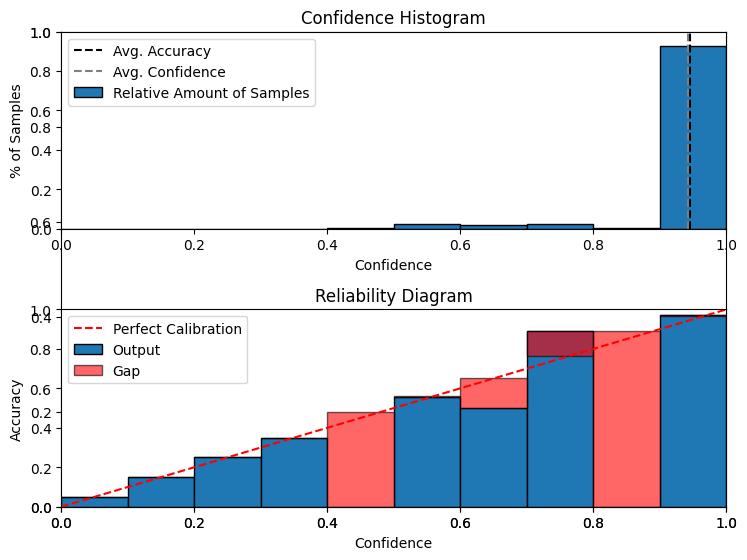

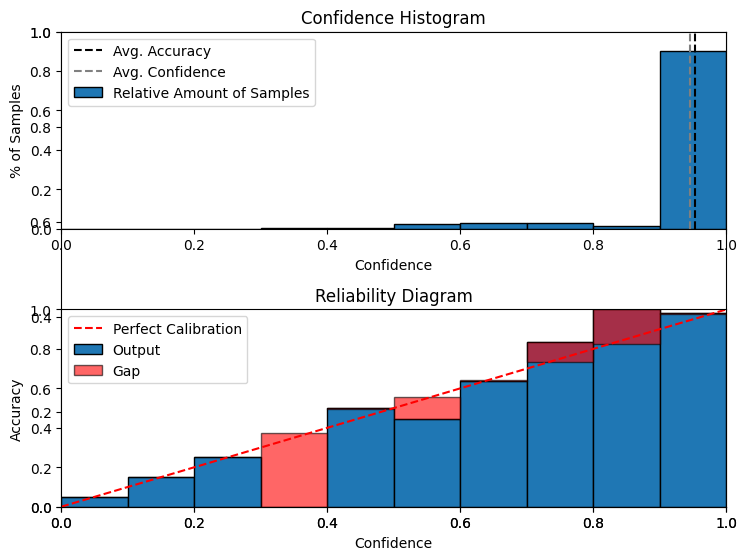

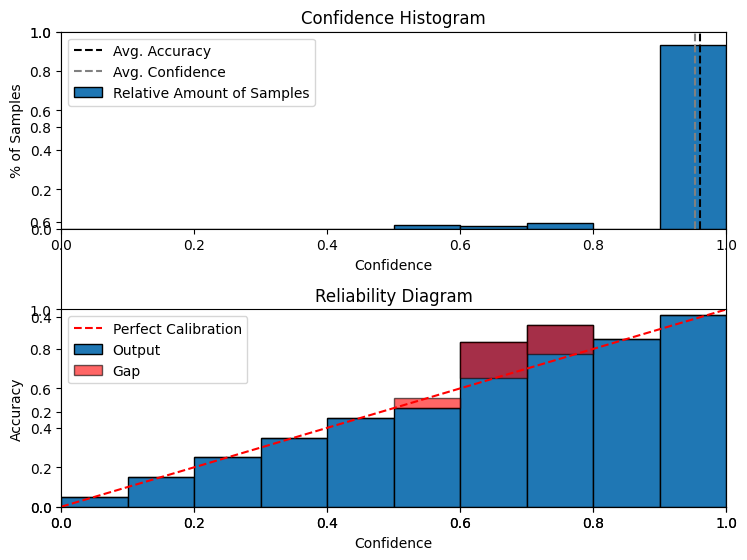

In [7]:
def evaluate_with_calibration(model_type, dataloader, device, method="histogram", bins=10, args=None):
    """
    Evaluate model calibration using different methods and display results in a row with 3 columns.

    Args:
        model_type (str): Model type ("single", "deep_ensemble", "mc_dropout").
        dataloader (torch.utils.data.DataLoader): DataLoader for test dataset.
        device (torch.device): Device to run the model on.
        methods (list): List of calibration methods to use.
        bins (int): Number of bins for binning-based calibration.
        args (dict or None): Additional parameters for deep ensemble and MC Dropout.

    Returns:
        None
    """
    all_preds, all_labels = [], []
    
    # 🔹 Load Single Model
    if model_type == "single":
        model = SingleNetwork().to(device)
        model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_PATH, "SingleNetwork.pth"), map_location=device))
        model.eval()

        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            with torch.no_grad():
                preds = torch.softmax(model(X_batch), dim=1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(y_batch.cpu().numpy())

    # 🔹 Load Deep Ensemble
    elif model_type == "deep_ensemble":
        models = []
        ensemble_size = args.get("ensemble_size", 5) if args else 5  # Default ensemble size

        for i in range(ensemble_size):
            model = SingleNetwork().to(device)
            model_path = os.path.join(MODEL_SAVE_PATH, f"DeepEnsemble_{i}.pth")
            if not os.path.exists(model_path):
                print(f"Missing Deep Ensemble model: {model_path}")
                continue
            model.load_state_dict(torch.load(model_path, map_location=device))
            model.eval()
            models.append(model)

        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            with torch.no_grad():
                preds = torch.stack([torch.softmax(model(X_batch), dim=1) for model in models])
                mean_preds = preds.mean(dim=0)
            all_preds.append(mean_preds.cpu().numpy())
            all_labels.append(y_batch.cpu().numpy())

    # 🔹 Load MC Dropout
    elif model_type == "mc_dropout":
        model = MCDropoutNetwork().to(device)
        model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_PATH, "MCDropout.pth"), map_location=device))
        model.eval()
        enable_dropout(model)  # Keep dropout active for uncertainty estimation

        num_samples = args.get("num_samples", 50) if args else 50  # Default num_samples

        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            with torch.no_grad():
                preds = torch.stack([torch.softmax(model(X_batch), dim=1) for _ in range(num_samples)])
                mean_preds = preds.mean(dim=0)
            all_preds.append(mean_preds.cpu().numpy())
            all_labels.append(y_batch.cpu().numpy())

    else:
        raise ValueError(f"Invalid model type: {model_type}")

    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # 🔹 Compare Calibration Methods
    ece_scores = {}
    figs = []
    methods = {
        "histogram": HistogramBinning(bins=bins),
        # "temperature_scaling": TemperatureScaling(),
        # "beta_calibration": BetaCalibration()    
    }
    
    
    for method_name, method in methods.items():
        method.fit(all_preds, all_labels)
        calibrated_preds = method.transform(all_preds)
        ece = ECE(bins=bins)
        ece_val = ece.measure(calibrated_preds, all_labels)
        ece_scores[method_name] = ece_val

        # 🔹 Generate Reliability Diagram
        fig = plt.figure(figsize=(8, 6))
        reliability_diagram = ReliabilityDiagram()
        reliability_diagram.plot(calibrated_preds, all_labels, ax=plt.gca(), fig=fig)
        figs.append(fig)
    
    return ece_scores, figs
    

ece_scores_single_net, _ = evaluate_with_calibration("single", test_loader, DEVICE)
print(f"Single Network ECE Scores: {ece_scores_single_net}")

ece_scores_deep_ensemble, _ = evaluate_with_calibration("deep_ensemble", test_loader, DEVICE, args={"ensemble_size": ENSEMBLE_SIZE})
print(f"Deep Ensemble ECE Scores: {ece_scores_deep_ensemble}")

ece_scores_mc_dropout, _ = evaluate_with_calibration("mc_dropout", test_loader, DEVICE, args={"num_samples": 15})
print(f"MC Dropout ECE Scores: {ece_scores_mc_dropout}")

In [ ]:
import os, sys
PATH = os.path.abspath(os.path.join("../../"))
sys.path.append(PATH)
from utils.utils import get_dataloaders
from src.models.models import FineTunedEfficientNetB7, FineTunedInceptionV3
from src.uncertainty_Quantification.train import train_model


train_loader, val_loader, cal_loader, test_loader = get_dataloaders( batch_size=32, num_workers=5)

# 📌 Single Network
model = FineTunedEfficientNetB7(num_classes=5)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10, model_name="SingleNetwork_mf")

    

/home/conite/anaconda3/envs/GPU_ENV/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/conite/anaconda3/envs/GPU_ENV/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO:SingleNetwork_mf:Starting training for SingleNetwork_mf


Training SingleNetwork_mf for 10 epochs


In [ ]:


import os, sys
PATH = os.path.abspath(os.path.join( "../../"))
sys.path.append(PATH)
from utils.utils import get_dataloaders
from src.uncertainty_Quantification.train import train_model, train_deep_ensemble
from src.uncertainty_Quantification.test import evaluate_model, monte_carlo_dropout, evaluate_mc_dropout
from src.uncertainty_Quantification.models import FineTunedResNet50

dropout_rate = 0.4
learning_rate = 0.001
num_epochs = 50
num_samples, ensemble_size = 10, 10
train_loader, val_loader, cal_loader, test_loader = get_dataloaders( batch_size=32, num_workers=4, model_type="resnet")

model = FineTunedResNet50(num_classes=5, mc_dropout=False, dropout_rate=dropout_rate)
# model_path = PATH + "/outputs/models/SingleNetwork_finetuned_resnet50.pth"
# model.load_state_dict(torch.load(model_path))
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=num_epochs, model_name="SingleNetwork_finetuned_resnet50")
res_single_resnet50 = evaluate_model(model, test_loader, model)
print(f"Single Network ResNet50 Test Performance: {res_single_resnet50}")


APS, RAPS, SAPS

In [78]:
import torch
import os
import json
import pandas as pd
from tqdm import tqdm
from torchcp.classification.score import APS, RAPS, SAPS, KNN, TOPK
from torchcp.classification.predictor import SplitPredictor
from utils.utils import set_seed, enable_dropout



def mc_dropout_forward(model, x, num_samples=10):
    """
    Runs Monte Carlo Dropout forward pass and returns
    the softmax output for each sample.
    """
    enable_dropout(model)
    with torch.no_grad():
        outputs = torch.stack([torch.softmax(model(x), dim=1) for _ in range(num_samples)])
    return outputs

def dee_ensemble_forward(models, x):
    """_summary_

    Args:
        models (_type_): _description_
        x (_type_): _description_
    """
    with torch.no_grad():
        outputs = torch.stack([torch.softmax(model(x), dim=1) for model in models])
    return outputs
    

def gather_logits_labels(model, loader, device, mc_dropout=False, mc_samples=10, ensemble_models=None):
    """
    Gathers model logits and true labels for calibration.

    Args:
        model (nn.Module): Base classification model.
        loader (torch.utils.data.DataLoader): DataLoader for calibration/test set.
        device (torch.device): Device to run the model on.
        mc_dropout (bool): Whether to use MC Dropout.
        mc_samples (int): Number of MC samples.
        ensemble_models (list or None): List of models for ensemble learning.

    Returns:
        Tuple[np.ndarray, np.ndarray]: Logits and true labels.
    """
    model.to(device).eval()
    all_logits, all_labels = [], []

    for X_batch, y_batch in tqdm(loader, desc="Gathering Logits"):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        if mc_dropout:
            preds = torch.stack([torch.softmax(model(X_batch), dim=1) for _ in range(mc_samples)])
            logits = preds.mean(dim=0)

        elif ensemble_models:
            preds = torch.stack([torch.softmax(m(X_batch), dim=1) for m in ensemble_models])
            logits = preds.mean(dim=0)

        else:
            logits = torch.softmax(model(X_batch), dim=1)

        all_logits.extend(logits.cpu().detach().numpy())
        all_labels.extend(y_batch.cpu().detach().numpy())
        
        
    all_logits = np.array(all_logits)
    all_labels = np.array(all_labels)

    return all_logits, all_labels


import torch
import os
import pandas as pd
from tqdm import tqdm
from torchcp.classification.score import APS, RAPS, SAPS
from torchcp.classification.predictor import SplitPredictor
from utils.utils import set_seed, enable_dropout

def posthoc_conformal_calibration(
    model, cal_loader, test_loader, device=None, alpha=0.1, seed=42,
    num_classes=5, mc_dropout=False, mc_samples=10, ensemble_models=None,
    save_results_dir="../../outputs/conformal_results/"
):
    """
    Runs Conformal Prediction (APS, RAPS, SAPS) on SingleNet, Monte Carlo Dropout, and Deep Ensembles.
    Computes accuracy-per-set-size trade-offs and saves the best method.

    Args:
        model (nn.Module): Base classification model.
        cal_loader, test_loader: DataLoaders for calibration/test sets.
        device (torch.device or None): CPU/GPU. If None, auto-detect.
        alpha (float): Significance level (1 - coverage).
        seed (int): Random seed for reproducibility.
        num_classes (int): Number of classes.
        mc_dropout (bool): Whether to use MC Dropout.
        mc_samples (int): Number of MC samples.
        ensemble_models (list or None): List of models for ensemble learning.
        save_results_dir (str): Directory to save results.

    Returns:
        pd.DataFrame: Results DataFrame.
    """
    set_seed(seed)
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    os.makedirs(save_results_dir, exist_ok=True)

    model.to(device).eval()
    if ensemble_models:
        for m in ensemble_models:
            m.to(device).eval()

    print(f"\n[INFO] Running post-hoc conformal calibration on {device}")
    print(f"[INFO] Using {'Ensemble Learning' if ensemble_models else 'Single Model'}")
    print(f"[INFO] Monte Carlo Dropout: {mc_dropout}, MC Samples: {mc_samples}")

    # ✅ Define Score Methods
    score_methods = {
        "APS": APS(score_type="softmax", randomized=True),
        "RAPS": RAPS(score_type="softmax", randomized=True, penalty=0.1, kreg=2),
        "SAPS": SAPS(score_type="softmax", randomized=True, weight=0.2),
    }

    predictor_classes = {
        "single": {"SplitPredictor": SplitPredictor},
        "ensemble": {"SplitPredictor": SplitPredictor},
        "mc_dropout": {"SplitPredictor": SplitPredictor}
    }

    results_list = []

    for method in tqdm(["single", "ensemble", "mc_dropout"], desc="Processing Conformal Types"):
        print(f"\n[INFO] Processing Type: {method}")

        # ✅ Gather Logits & Labels
        cal_logits, cal_labels = gather_logits_labels(
            model, cal_loader, device,
            mc_dropout=(method == "mc_dropout"), mc_samples=mc_samples,
            ensemble_models=ensemble_models if method == "ensemble" else None
        )
        test_logits, test_labels = gather_logits_labels(
            model, test_loader, device,
            mc_dropout=(method == "mc_dropout"), mc_samples=mc_samples,
            ensemble_models=ensemble_models if method == "ensemble" else None
        )

        for score_name, score_obj in score_methods.items():
            for predictor_name, predictor_cls in predictor_classes[method].items():
                predictor = predictor_cls(score_function=score_obj, model=model)

                # ✅ Calibrate Predictor
                predictor.calibrate(cal_loader, alpha=alpha)
                result_dict = predictor.evaluate(test_loader)

                # ✅ Compute Set Size Statistics
                set_sizes = []
                for X_batch, _ in test_loader:
                    X_batch = X_batch.to(device)
                    pred_sets = predictor.predict(X_batch)
                    set_sizes.extend([len(pred) for pred in pred_sets])

                mean_set_size = torch.tensor(set_sizes).float().mean().item()
                median_set_size = torch.tensor(set_sizes).float().median().item()
                std_set_size = torch.tensor(set_sizes).float().std().item()
                accuracy_per_set_size = result_dict['coverage_rate'] / mean_set_size if mean_set_size > 0 else 0

                print(f"[RESULT] {score_name}-{predictor_name}: Coverage={result_dict['coverage_rate']:.4f}, "
                      f"Mean Set Size={mean_set_size:.2f}, Median Set Size={median_set_size:.2f}, Std={std_set_size:.2f}, "
                      f"Acc/SetSize={accuracy_per_set_size:.4f}")

                # ✅ Store Results
                results_list.append({
                    "Type": method,
                    "ScoreMethod": score_name,
                    "Predictor": predictor_name,
                    "CoverageRate": result_dict['coverage_rate'],
                    "MeanSetSize": mean_set_size,
                    "MedianSetSize": median_set_size,
                    "StdSetSize": std_set_size,
                    "AccuracyPerSetSize": accuracy_per_set_size,
                })


    results_df = pd.DataFrame(results_list)
    results_df.to_csv(os.path.join(save_results_dir, "conformal_results.csv"), index=False)

    print("\n[INFO] Conformal Calibration Results Saved.")
    return results_df


In [79]:
OUTPATH = os.path.join(PATH, "outputs/conformal_results")
train_loader = get_dataloader("train", BATCH_SIZE)
val_loader = get_dataloader("val", BATCH_SIZE)
cal_loader = get_dataloader("cal", BATCH_SIZE)
test_loader = get_dataloader("test", BATCH_SIZE)
model = SingleNetwork(input_dim, num_classes).to(DEVICE)
ENSEMBLE_SIZE=10

from src.uncertainty_Quantification.models import SingleNetwork, MCDropoutNetwork, DeepEnsemble


deep_ens = [SingleNetwork(input_dim, num_classes).to(DEVICE) for _ in range(ENSEMBLE_SIZE)]
for i in range(ENSEMBLE_SIZE):
    deep_ens[i].load_state_dict(torch.load(PATH + f"/outputs/models/DeepEnsemble_{i}.pth"))

results_df = posthoc_conformal_calibration(
    model=model, 
    cal_loader=cal_loader, 
    test_loader=test_loader, 
    device=DEVICE, 
    alpha=0.1,
    mc_dropout=True,
    mc_samples=10,
    ensemble_models=deep_ens,
    save_results_dir=OUTPATH
)


/tmp/ipykernel_1297033/3362614448.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  deep_ens[i].load_state_dict(torch.load(PATH + f"/outputs/models/DeepEnsemble_{i}.pth")


[INFO] Running post-hoc conformal calibration on cpu
[INFO] Using Ensemble Learning
[INFO] Monte Carlo Dropout: True, MC Samples: 10


Processing Conformal Types:   0%|          | 0/3 [00:00<?, ?it/s]


[INFO] Processing Type: single


Gathering Logits: 100%|██████████| 13/13 [00:00<00:00, 194.15it/s]


[RESULT] APS-SplitPredictor: Coverage=0.8990, Mean Set Size=5.00, Median Set Size=5.00, Std=0.00, Acc/SetSize=0.1798
[RESULT] RAPS-SplitPredictor: Coverage=0.8966, Mean Set Size=5.00, Median Set Size=5.00, Std=0.00, Acc/SetSize=0.1793


Processing Conformal Types:  33%|███▎      | 1/3 [00:00<00:01,  1.33it/s]

[RESULT] SAPS-SplitPredictor: Coverage=0.9089, Mean Set Size=5.00, Median Set Size=5.00, Std=0.00, Acc/SetSize=0.1818

[INFO] Processing Type: ensemble


Gathering Logits: 100%|██████████| 13/13 [00:00<00:00, 27.07it/s]


[RESULT] APS-SplitPredictor: Coverage=0.8645, Mean Set Size=5.00, Median Set Size=5.00, Std=0.00, Acc/SetSize=0.1729
[RESULT] RAPS-SplitPredictor: Coverage=0.9187, Mean Set Size=5.00, Median Set Size=5.00, Std=0.00, Acc/SetSize=0.1837


Processing Conformal Types:  67%|██████▋   | 2/3 [00:02<00:01,  1.36s/it]

[RESULT] SAPS-SplitPredictor: Coverage=0.8867, Mean Set Size=5.00, Median Set Size=5.00, Std=0.00, Acc/SetSize=0.1773

[INFO] Processing Type: mc_dropout


Gathering Logits: 100%|██████████| 13/13 [00:00<00:00, 26.47it/s]


[RESULT] APS-SplitPredictor: Coverage=0.9113, Mean Set Size=5.00, Median Set Size=5.00, Std=0.00, Acc/SetSize=0.1823
[RESULT] RAPS-SplitPredictor: Coverage=0.8892, Mean Set Size=5.00, Median Set Size=5.00, Std=0.00, Acc/SetSize=0.1778


Processing Conformal Types: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]

[RESULT] SAPS-SplitPredictor: Coverage=0.9064, Mean Set Size=5.00, Median Set Size=5.00, Std=0.00, Acc/SetSize=0.1813

[INFO] Conformal Calibration Results Saved.


Available Columns: ['Type', 'ScoreMethod', 'Predictor', 'CoverageRate', 'MeanSetSize', 'MedianSetSize', 'StdSetSize', 'AccuracyPerSetSize']


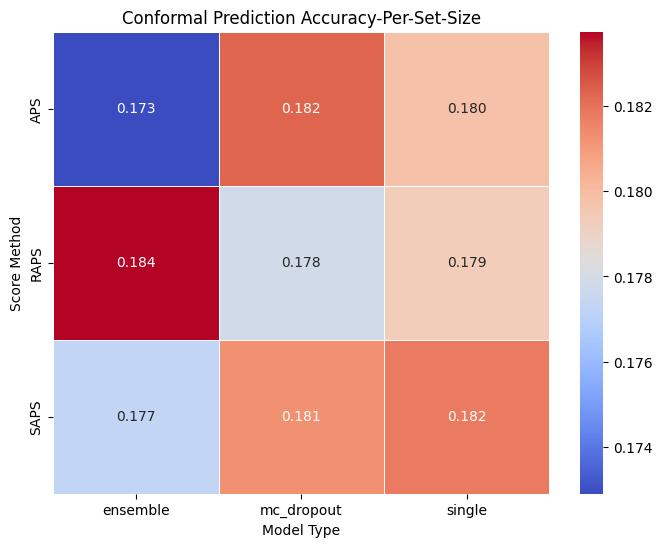

In [80]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Load Results
df = pd.read_csv( os.path.join(OUTPATH, "conformal_results.csv"))

# ✅ Print Columns to Confirm "AccuracyPerSetSize" Exists
print("Available Columns:", df.columns.tolist())

# ✅ Pivot Table for Heatmap
heatmap_data = df.pivot_table(values="AccuracyPerSetSize", index="ScoreMethod", columns="Type")

# ✅ Generate Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="coolwarm", linewidths=0.5)
plt.title("Conformal Prediction Accuracy-Per-Set-Size")
plt.xlabel("Model Type")
plt.ylabel("Score Method")
plt.show()


**Finetuning**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import os

# Define FineTuned ResNet50
class FineTunedResNet50(nn.Module):
    def __init__(self, num_classes, pretrained=True, mc_dropout=False, dropout_rate=0.5):
        super(FineTunedResNet50, self).__init__()
        self.model = models.resnet50(pretrained=pretrained)
        
        for param in self.model.parameters():
            param.requires_grad = False
        for param in self.model.layer4.parameters():
            param.requires_grad = True
        
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate) if mc_dropout else nn.Identity(),
            nn.Linear(self.model.fc.in_features, 1024),
            nn.ReLU(),
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        return self.model(x)

# Paths
PROJECT_ROOT = os.path.abspath(os.path.join("../../"))
MODEL_SAVE_PATH = os.path.join(PROJECT_ROOT, "outputs/models/FineTunedResNet50.pth")

# Hyperparameters
num_classes = 5
dropout_rate = 0.4
learning_rate = 0.0001
num_epochs = 50

from utils.utils import get_dataloaders
from src.uncertainty_Quantification.train import train_model
from src.uncertainty_Quantification.test import evaluate_model


train_loader, val_loader, cal_loader, test_loader = get_dataloaders(batch_size=32, num_workers=4, model_type="resnet")

resnet50_model = FineTunedResNet50(num_classes=num_classes, mc_dropout=False)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet50_model.parameters()), lr=learning_rate)
train_model(resnet50_model, train_loader, val_loader, criterion, optimizer, num_epochs, "FineTunedResNet50")

torch.save(resnet50_model.state_dict(), MODEL_SAVE_PATH)
print(f"Model saved at: {MODEL_SAVE_PATH}")
# Load Model for Evaluation
resnet50_model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location="cuda" if torch.cuda.is_available() else "cpu"))
# Evaluate Model
res_resnet50 = evaluate_model(resnet50_model, test_loader, "FineTunedResNet50")
print(f"Fine-Tuned ResNet50 Test Performance: {res_resnet50}")

#=====================
# monte carlo dropout
#=====================
resnet50_mcd = FineTunedResNet50(num_classes=num_classes, mc_dropout=True, dropout_rate=dropout_rate)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet50_mcd.parameters()), lr=learning_rate)
train_model(resnet50_mcd, train_loader, val_loader, criterion, optimizer, num_epochs, "FineTunedResNet50_MCD")
res_resnet50_mcd = evaluate_mc_dropout(resnet50_mcd, test_loader, "FineTunedResNet50_MCD", n_samples=10)
print(f"Fine-Tuned ResNet50 MC Dropout Test Performance: {res_resnet50_mcd}")

# Deep Ensemble
ensemble_size = 10
ensemble_models = [FineTunedResNet50(num_classes=num_classes, mc_dropout=False).to("cuda" if torch.cuda.is_available() else "cpu") for _ in range(ensemble_size)]
train_deep_ensemble(
    train_loader, 
    val_loader, 
    ensemble_size=ensemble_size, 
    learning_rate=learning_rate, 
    epochs=num_epochs, 
    model_name="FineTunedResNet50_DE", 
    criterion=criterion, 
    optimizer=optimizer, 
    patience=10,
    models=ensemble_models    
)
res_deep_ensemble = evaluate_deep_ensemble(test_loader, ensemble_size)
print(f"Fine-Tuned ResNet50 Deep Ensemble Test Performance: {res_deep_ensemble}")


In [ ]:
import os
import torch
MODEL_SAVE_PATH = os.path.join(PROJECT_ROOT, "outputs/models")
from src.uncertainty_Quantification.models import FineTunedResNet50

model = FineTunedResNet50(num_classes=5, mc_dropout=False, dropout_rate=0.4)
model_path = os.path.join(MODEL_SAVE_PATH, "SingleNetwork_finetuned_resnet50.pth")


if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file not found at: {model_path}")
print(f"✅ Model file found: {model_path}")

# ✅ Load Model
model.load_state_dict(torch.load(model_path, map_location=DEVICE))
model.to(DEVICE)
model.eval()
